In [4]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import os
import seaborn as sb
import sys
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
sc.settings.verbosity = 3      


In [5]:
sys.path.append('/home/aih/shrey.parikh/cross_species/cross_system_integration')

In [6]:
from cross_system_integration.model._xxjointmodel import XXJointModel

Global seed set to 0


In [7]:
adata_house = sc.read_h5ad('adata_human_mouse_hvgcomb.h5ad')

In [18]:
adata_house

AnnData object with n_obs × n_vars = 115589 × 1099
    obs: 'Sample', 'ID', 'Batch', 'annotation_nodoub_2', 'System', 'Organism'
    var: 'input'
    uns: 'system_order', 'covariate_orders', 'covariates_dict', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_scVI', 'X_scVI_nodoub_pca', 'X_scVI_nodoub_umap', 'X_scVI_nodoub_umap_1', 'X_scVI_pca', 'X_scVI_umap', 'X_scVI_umap_1', 'system', 'covariates', 'X_umap'
    layers: 'counts', 'raw'

In [6]:
adata_house.obs

,Sample,ID,Batch,annotation_nodoub_2,System
AAACCCAAGTATAGAC-1,10wpc_1,NaN,JS,Beta,1
AAACGAACATTAGGAA-1,10wpc_1,NaN,JS,Ductal,1
AAACGAATCGAACCTA-1,10wpc_1,NaN,JS,Ductal,1
AAACGAATCGGATACT-1,10wpc_1,NaN,JS,Ductal,1
AAACGCTAGGCAGCTA-1,10wpc_1,NaN,JS,Acinar,1
...,...,...,...,...,...
TCAGGATAGTGTGGCA_E9.5,E9.5Posterior,GSE136689,AZ,Acinar,0
TCATTACGTTATCACG_E9.5,E9.5Posterior,GSE136689,AZ,Ductal,0
TCGCGTTCACGGACAA_E9.5,E9.5Posterior,GSE136689,AZ,Acinar,0
TTCTACATCACTCTTA_E9.5,E9.5Posterior,GSE136689,AZ,Acinar,0


In [9]:
adata_house.obs['Organism'] = adata_house.obs.System.map({0:'Mouse', 1:'Human'})
adata_training = XXJointModel.setup_anndata(
    adata=adata_house,
    system_key='Organism',
    group_key=None,
    categorical_covariate_keys=['Batch'],
)

INFO     Using column names from columns of adata.obsm['covariates']                                               
INFO     Using column names from columns of adata.obsm['system']                                                   


In [10]:
model = XXJointModel(
    adata=adata_training,
    out_var_mode='feature',
    mixup_alpha=None,
    system_decoders=False,
    prior='vamp',
    n_prior_components=5,
    pseudoinputs_data_init=True,
    trainable_priors=True,
    encode_pseudoinputs_on_eval_mode=True,
    z_dist_metric = 'MSE_standard',
    n_layers=2,
    n_hidden=256)

In [11]:
import pytorch_lightning as pl
model.train(
    max_epochs=80,
    log_every_n_steps=1,
    check_val_every_n_epoch=1,
    val_check_interval=1.0,
    train_size=0.9,
    plan_kwargs={
        'optimizer': "Adam",
        'lr': 0.001,
        'reduce_lr_on_plateau': False,
        'lr_scheduler_metric': 'loss_train',  # Replace with default value
        'lr_patience': 5,  # Replace with default value
        'lr_factor': 0.1,  # Replace with default value
        'lr_min': 1e-7,  # Replace with default value
        'lr_threshold_mode': 'rel',  # Replace with default value
        'lr_threshold': 0.1,  # Replace with default value
        'log_on_epoch': True,  # Replace with default value
        'log_on_step': False,  # Replace with default value
        'loss_weights': {
            'kl_weight': 1.0,  # Replace with default value
            'kl_cycle_weight': 0.0,  # Replace with default value
            'reconstruction_weight': 1.0,  # Replace with default value
            'reconstruction_mixup_weight': 0.0,  # Replace with default value
            'reconstruction_cycle_weight': 0.0,
            'z_distance_cycle_weight': 5.0, 
            'translation_corr_weight': 0.0,  # Replace with default value
            'z_contrastive_weight': 0.0,  # Replace with default value
        },
    }
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 80/80: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [17:35<00:00, 13.19s/it, loss=-767, v_num=1]


In [12]:
embed_full_t5 = model.embed(
    adata=adata_training,
    indices=None,
    batch_size=None,
    as_numpy=True)
embed_full_t5=sc.AnnData(embed_full_t5,obs=adata_training.obs)
# Make system categorical for eval as below
embed_full_t5.obs['Organism']=embed_full_t5.obs['Organism'].astype(str)
embed_full_t5.write('test_run_5_embed.h5ad')

In [13]:
sc.pp.neighbors(embed_full_t5, use_rep='X')
sc.tl.umap(embed_full_t5)

computing neighbors


/home/aih/shrey.parikh/miniconda3/envs/cross_species/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/aih/shrey.parikh/miniconda3/envs/cross_species/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/aih/shrey.parikh/miniconda3/

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:52)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:14)


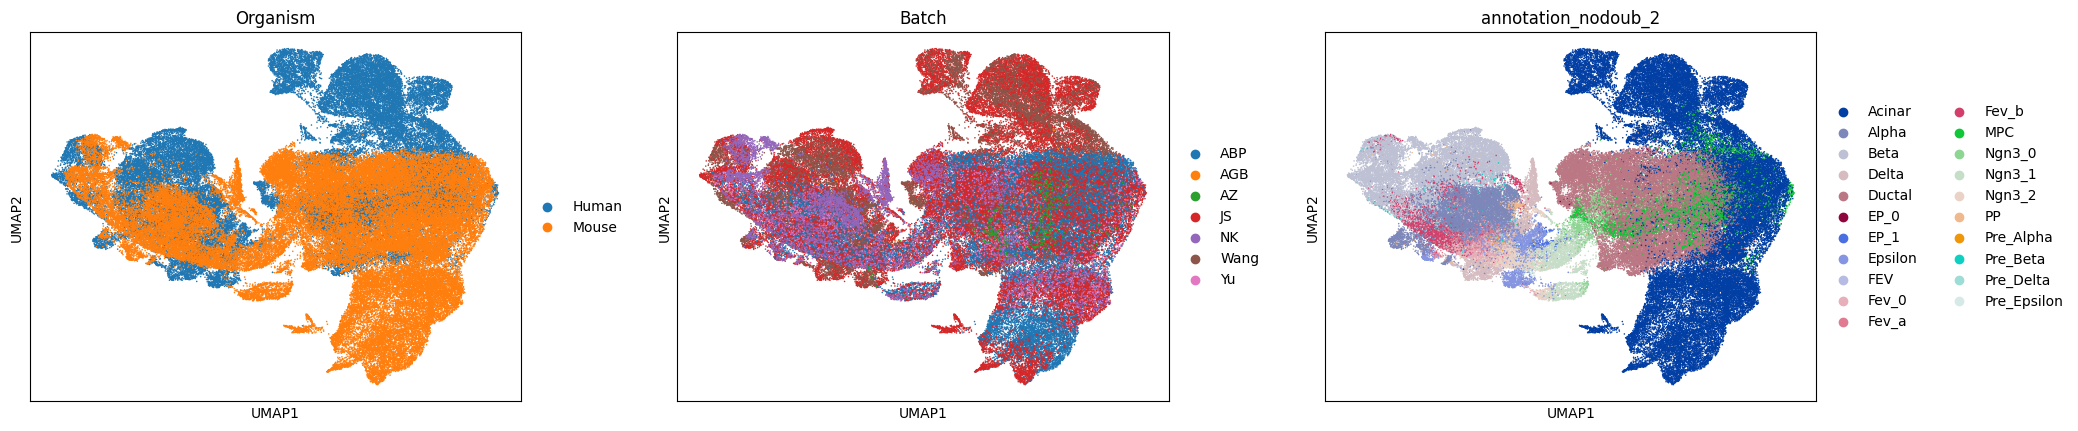

In [14]:
sc.pl.umap(embed_full_t5, color=['Organism', 'Batch', 'annotation_nodoub_2'], size=5, wspace=0.2)

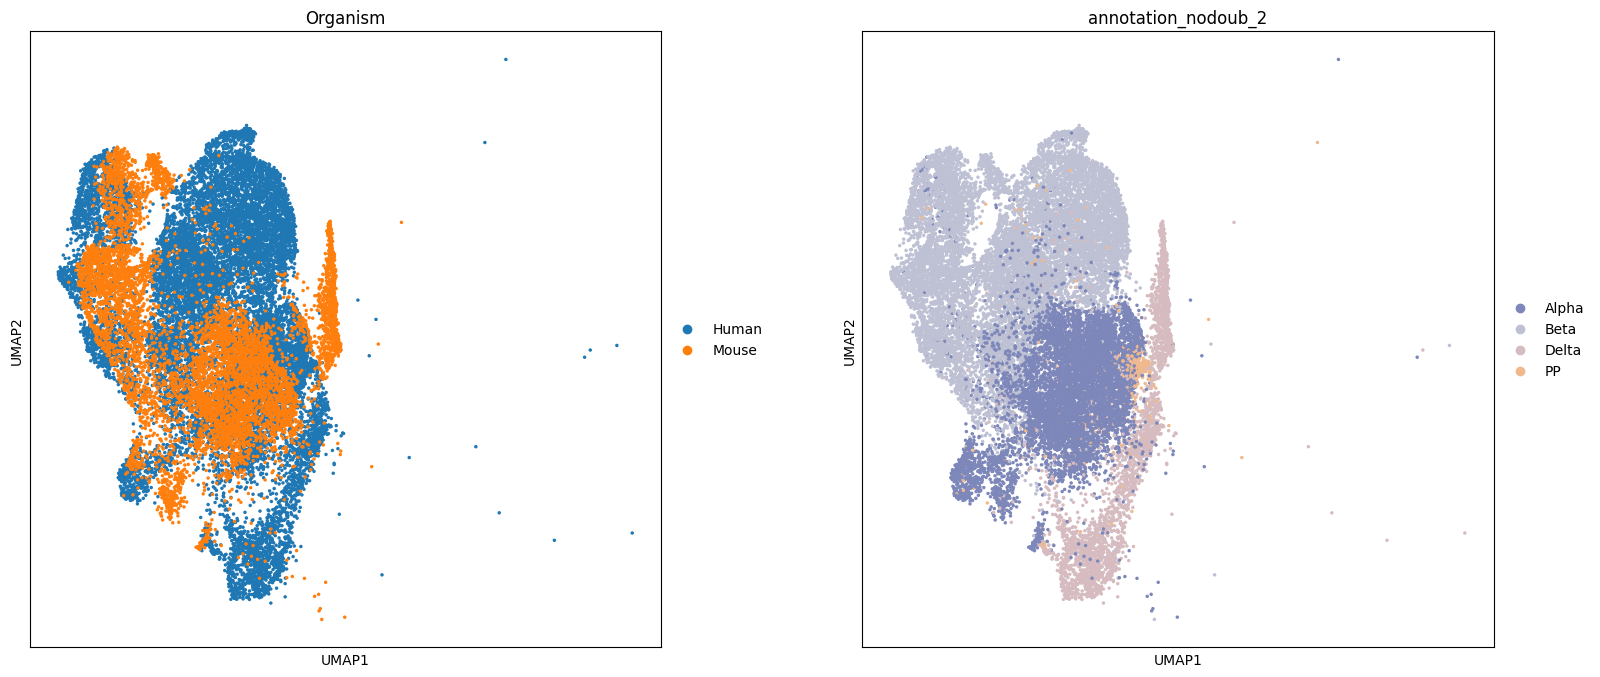

In [15]:
 plt.rcParams['figure.figsize'] = (8,8)
sc.pl.umap(embed_full_t5[embed_full_t5.obs.annotation_nodoub_2.isin(['Alpha','Beta','Delta', 'PP'])], color=['Organism','annotation_nodoub_2'], size=25, wspace=0.2)

In [16]:
adata_house.obsm['X_umap'] = embed_full_t5.obsm['X_umap']

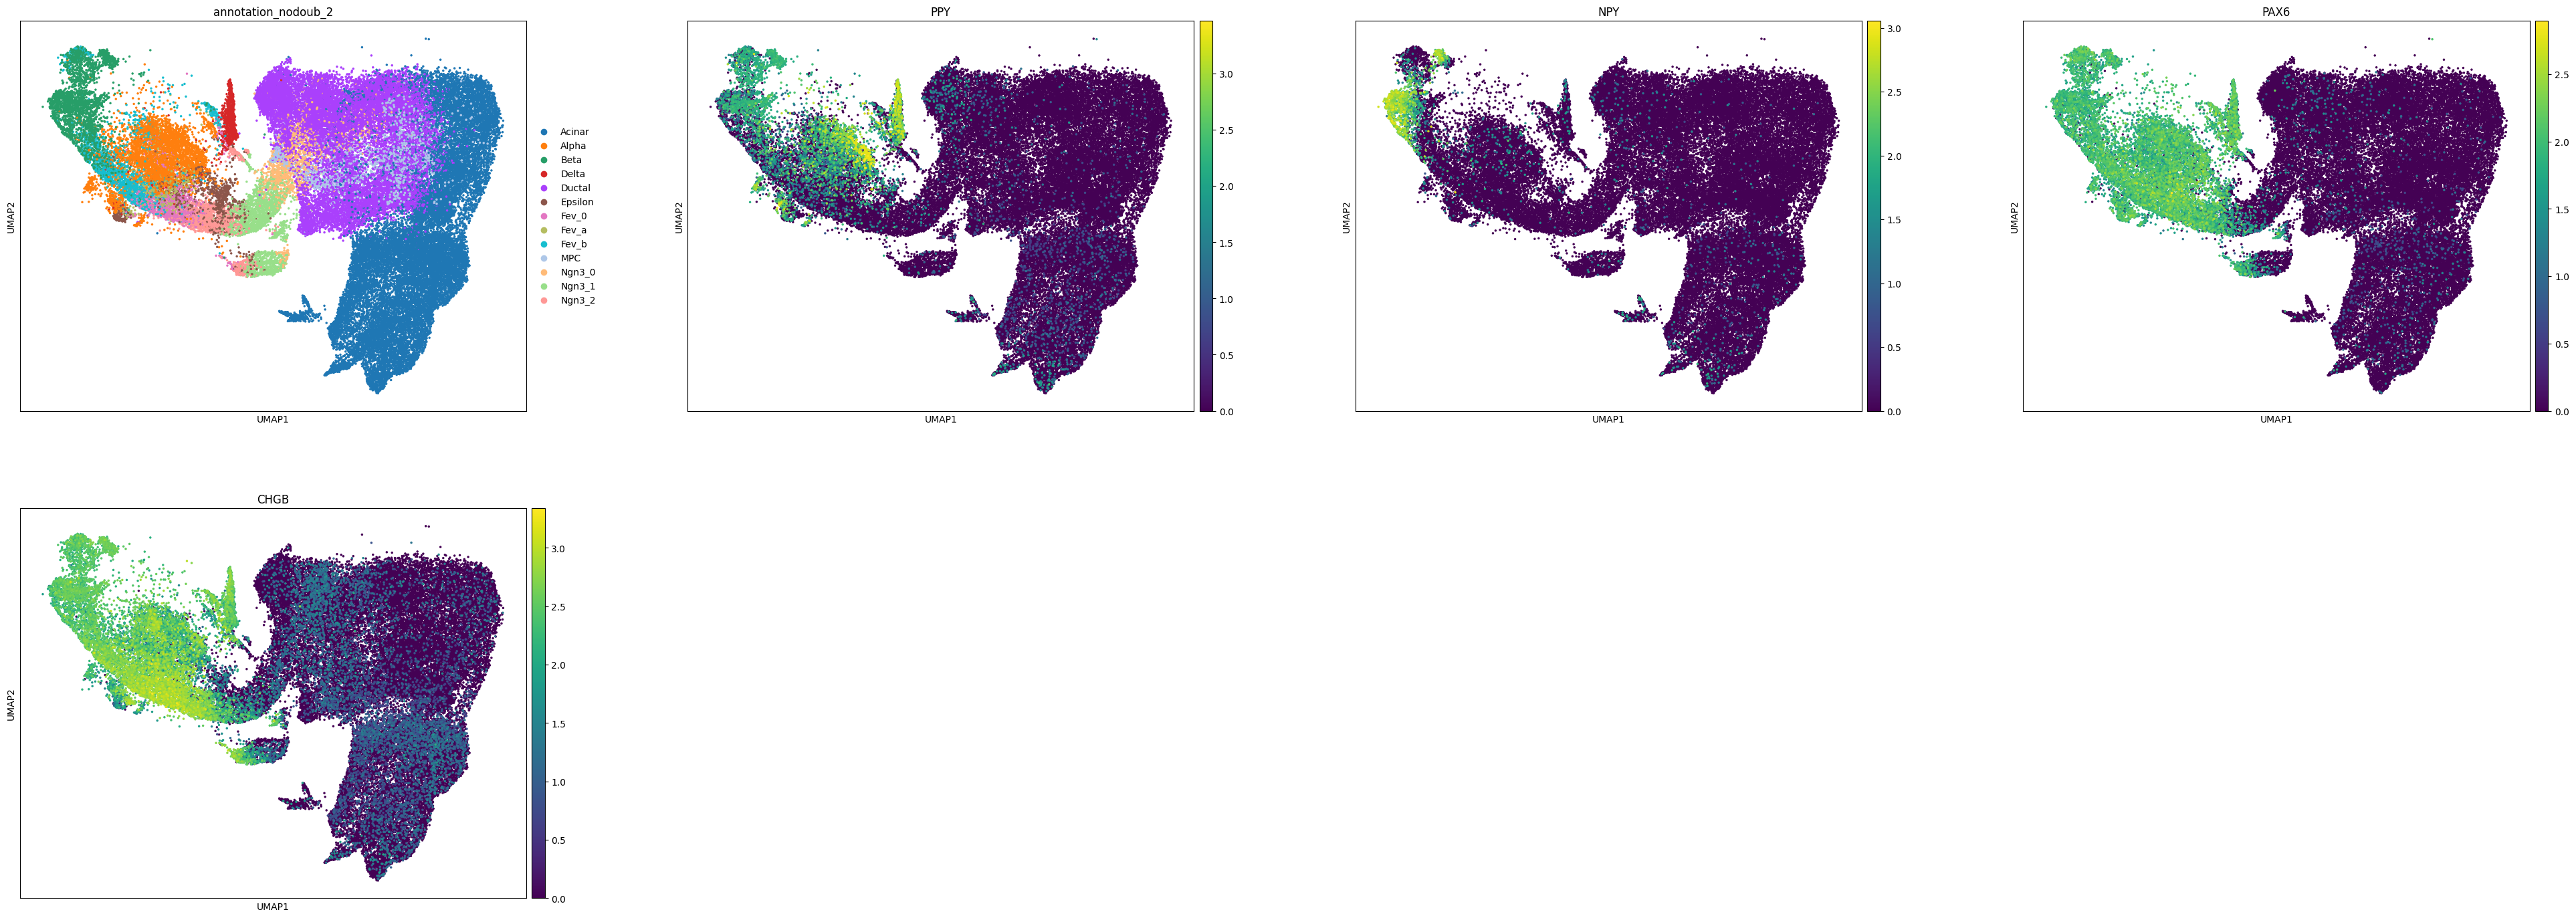

In [17]:
plt.rcParams['figure.figsize'] = (10,8)
sc.pl.umap(adata_house[adata_house.obs.Organism == 'Mouse'], color=['annotation_nodoub_2','PPY', 'NPY',  'PAX6', 'CHGB'] , size=25, wspace=0.2)